# Imports

In [182]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import clear_output

%matplotlib inline
set_seed = torch.manual_seed(0)

# Data generator

In [183]:
fmnist = torchvision.datasets.FashionMNIST(root = "/home/pachy/Desktop/ACSAI/acsai/Deep Learning/Class/Exercises/mlp_fromscratch/FashionMNIST",
                                           download = True)

In [184]:
fmnist.test_data.shape

/home/pachy/.cache/pypoetry/virtualenvs/dlcourse-BfLxQsIA-py3.11/lib/python3.11/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([60000, 28, 28])

# Model


In [185]:
class MLP(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hidden_units, num_hidden_layers = 1):
        super().__init__()
        hiddens = [(torch.nn.Linear(num_hidden_units, num_hidden_units), torch.nn.ReLU()) for x in range(num_hidden_layers - 1)]
        self.model = torch.nn.Sequential(torch.nn.Flatten(),
                                        torch.nn.Linear(in_features=num_inputs, 
                                                         out_features=num_hidden_units),
                                        torch.nn.ReLU(),
                                        *hiddens,
                                        torch.nn.Linear(in_features=num_hidden_units,
                                                        out_features=num_outputs))       
        
    def forward(self, x):
        x = x.to(torch.float32)
        return self.model(x)

# Trainer

In [186]:
class Trainer:
    def __init__(self, model, loss, optimizer, batchsize = 32, epochs = 5):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.epochs = epochs
        self.batchsize = batchsize

    def live_plot(self, train_loss, val_loss, val_accuracy, figsize=(7,5), title='Loss per epoch'):
        '''
        It plots only the average loss per epoch.
        '''
        train_loss = train_loss.astype('float64')
        val_loss = val_loss.astype('float64')
        #val_accuracy = val_accuracy.astype('float64')
        x = np.arange(train_loss.size[0])

        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.plot(x, train_loss, label = "Training loss")
        plt.plot(x, val_loss, label = "Validation loss")
        #plt.plot(x, val_accuracy, label = "Validation accuracy")
        plt.show()
        
    def fit_model(self, training_set, training_labels, validation_set, validation_labels):
        '''
        A function that creates the training data,
        optimizes the model and plots the results.
        '''
        
        train_loss = np.array([])
        val_loss = np.array([])
        val_accuracy = np.array([])

        iterations = training_set.shape[0]//self.batchsize

        for i in range(self.epochs):
            for j in range(iterations):
                # Data loading  
                x = training_set[j*self.batchsize:(j+1)*self.batchsize]
                y = training_labels[j*self.batchsize:(j+1)*self.batchsize].to(torch.int64)

                # Loss computation
                self.model.train()
                y_hat = self.model.forward(x)
                print(y_hat[0])
                print(f"Prediction type is {y_hat.dtype} of shape {y_hat.shape}")
                print(y)
                print(f"Class type is {y.dtype} of shape {y.shape}")
                loss = self.loss(y_hat, y)
                train_loss = np.append(train_loss, loss.detach().numpy())   # this is needed for plotting

                # Optimization
                loss.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                
                # Validation
                with torch.no_grad():
                    self.model.eval()
                    x = validation_set[j*self.batchsize:(j+1)*self.batchsize]
                    y = validation_labels[j*self.batchsize:(j+1)*self.batchsize]
                    y_hat = self.model.forward(x)
                    loss = self.loss(y, y_hat)
                    val_loss = np.append(val_loss, loss)   # this is needed for plotting

                # Updating the training plot
                self.live_plot(train_loss, val_loss, val_accuracy)        

# Training tests


## Normal training

In [187]:
# We first need to create the dataset
training_set = fmnist.data[:1000]
training_labels = fmnist.targets[:1000]
val_set = fmnist.data[-1000:]
val_labels = fmnist.targets[-1000:]

model = MLP(num_inputs=28*28,
            num_hidden_units=256,
            num_hidden_layers=1,
            num_outputs=10)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
loss = torch.nn.functional.cross_entropy
trainer = Trainer(model, loss, optimizer, epochs=10)

trainer.fit_model(training_set, training_labels, val_set, val_labels)

tensor([ 35.6216, -16.5194, -58.2751,   5.3767,  17.1835, -42.3165,  49.6992,
         63.5843,  19.6905,  -1.8996], grad_fn=<SelectBackward0>)
Prediction type is torch.float32 of shape torch.Size([32, 10])
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3])
Class type is torch.int64 of shape torch.Size([32])


RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'

## Training debugging

In [188]:
a = 100*(torch.rand(size=(32, 10))-0.5*torch.ones(size=(32, 10))).to(torch.float32)
print(a[0])
lab_a = training_labels[:32]
print(lab_a)

print(a.shape, a.dtype)
print(lab_a.shape, lab_a.dtype)

debug_loss = torch.nn.CrossEntropyLoss()
debug_loss(a, lab_a)

tensor([ -3.1556,  -2.7377,   9.9521,  28.6245,  11.9328,  28.8031,   2.6220,
         43.5725,  33.5562, -16.0243])
tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8,
        4, 3, 0, 2, 4, 4, 5, 3])
torch.Size([32, 10]) torch.float32
torch.Size([32]) torch.int64


tensor(42.6611)

In [183]:
training_set.to(torch.float64).shape

torch.Size([1000, 28, 28])

In [7]:
transform = torchvision.transforms.ToPILImage()

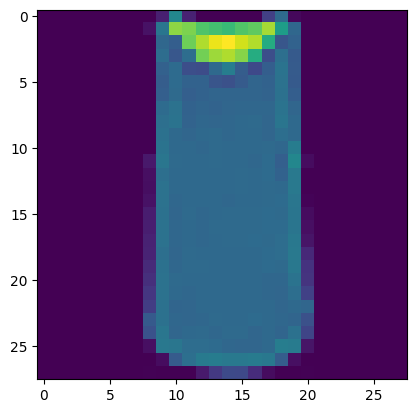

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

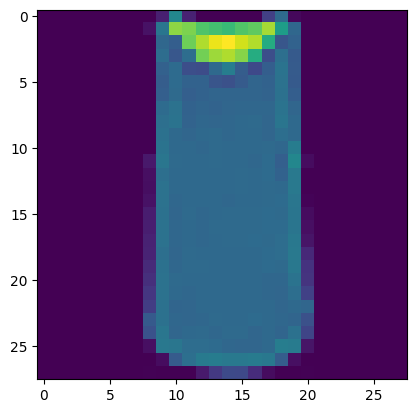

In [13]:
img = training_set[2].detach().numpy()
plt.imshow(img)
plt.show(img)